# Movie Recommender Systems 


Recommender systems play a vital role in today's technology-driven world by helping individuals make informed choices about the content they engage with on daily. This is particularly true for movie recommendations, where intelligent algorithms can assist viewers in discovering great titles from a vast selection. Have you ever wondered how streaming platforms like Netflix, Amazon Prime, Showmax, and Disney seem to know what to recommend to you? In this challenge we will walk you through our movie recommender.

The aim of the project is to build a movie recommender using both  content based filtering and collaborative based filtering methods.

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#pip install surprise


In [9]:
#firstly to import important libraries
import pandas as pd
import numpy as np
import io
#for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
#for processing the data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
#to display codes without warning
import warnings
warnings.filterwarnings('ignore')
# from surprise import Dataset
# from surprise import accuracy
# from surprise import Reader
# from surprise import SVD
# from surprise.model_selection import cross_validate


In [10]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mutis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading The Data

There are a few dataframes that are to be imported, so simply importing the data for now and having the information within displayed a little down the line will help keep the notebook more aestheticaly pleasing.

In [11]:
genome_scores=pd.read_csv("genome_scores.csv")
genome_tags=pd.read_csv("genome_tags.csv")
imdb_data= pd.read_csv("imdb_data.csv")
links= pd.read_csv("links.csv")
movies= pd.read_csv("movies.csv")
tags= pd.read_csv("tags.csv")
df_test=pd.read_csv("test.csv")
df_train= pd.read_csv("train.csv")

##  Exploratory Data Analysis (EDA)


It's clear that there is a lot of data to go through. This might prove dificult to provide an acurate analysis of the data. So to go through it with more ease, we create a basic EDA function to help show the basic information of each dataframe. this EDA function shows if the dataset has: missing values and also the position of the missing values, outliers and their position as well, check the data types, and lastly the correlation of the data.

In [12]:
def EDA(data):
    """Perform exploratory data analysis on a given dataset.
    Args:
      data (pandas.DataFrame): The dataset to analyze.
    """
    from IPython.display import display
    display(data.head())
    # Check for missing values
    if data.isnull().values.any():
        # Find the number of missing values for each column
        missing_counts = data.isnull().sum()
        # Select only the columns with missing values
        missing_columns = missing_counts[missing_counts > 0]
        print(f"Missing values found in columns: {missing_columns}")
    else:
        print("No missing values found")

    # Check for outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    if outliers.empty:
        print("No outliers found")
    else:
        print(f"Outliers found at positions: {outliers.index}")

    # Check data types
    data_types = data.dtypes
    print(f"Data types: {data_types}")

    # Check correlations
    correlations = data.corr()
    display(correlations)

With the function above, now it is easier going through each dataframe and perfom simple data exploration. Below, this step is completed swiftly.

In [13]:
#fitting the EDA function to the test data as well as the train data
EDA(df_train)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=10000038, step=1)
Data types: userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


,userId,movieId,rating,timestamp
userId,1.000000,-0.004270,0.002202,-0.001347
movieId,-0.004270,1.000000,-0.008940,0.520786
rating,0.002202,-0.008940,1.000000,0.010301
timestamp,-0.001347,0.520786,0.010301,1.000000


Let's do it again in the test dataset

In [14]:
EDA(df_test)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=5000019, step=1)
Data types: userId     int64
movieId    int64
dtype: object


,userId,movieId
userId,1.000000,-0.004401
movieId,-0.004401,1.000000


In [15]:
#firstly the genome score
EDA(genome_scores)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=15584448, step=1)
Data types: movieId        int64
tagId          int64
relevance    float64
dtype: object


,movieId,tagId,relevance
movieId,1.000000e+00,-1.390078e-13,0.015355
tagId,-1.390078e-13,1.000000e+00,0.017763
relevance,1.535521e-02,1.776320e-02,1.000000


In [16]:
#genome tags
EDA(genome_tags)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=1128, step=1)
Data types: tagId     int64
tag      object
dtype: object


,tagId
tagId,1.0


In [17]:
#for the imdb data
EDA(imdb_data)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


Missing values found in columns: title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=27278, step=1)
Data types: movieId            int64
title_cast        object
director          object
runtime          float64
budget            object
plot_keywords     object
dtype: object


,movieId,runtime
movieId,1.00000,-0.13273
runtime,-0.13273,1.00000


In [18]:
#the movies dataframe
EDA(movies)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId     int64
title      object
genres     object
dtype: object


,movieId
movieId,1.0


In [19]:
#now the tags
EDA(tags)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Missing values found in columns: tag    16
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=1093360, step=1)
Data types: userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


,userId,movieId,timestamp
userId,1.000000,-0.101326,-0.197582
movieId,-0.101326,1.000000,0.400216
timestamp,-0.197582,0.400216,1.000000


In [20]:
EDA(links)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Missing values found in columns: tmdbId    107
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId      int64
imdbId       int64
tmdbId     float64
dtype: object


,movieId,imdbId,tmdbId
movieId,1.000000,0.466805,0.581131
imdbId,0.466805,1.000000,0.820764
tmdbId,0.581131,0.820764,1.000000


From the above information, the data contains a few columns missing values, with  missing values found in the 'imdb_data' in only four columns and as well on 'tags' and 'links' having missing value. As for the outliers, the data seems have quite a few outliers. This could be due to the diversity of the data, how the data was entered or a myriad of other reasons. It might prove more fruitful to display the data numerical data and see how much of the data is outlier prone. The data types seem to show that the prominent datatypes are intergers and objects with only 2 columns being float datatypes.

#### Investigating columns with null values


We will have to see how much of the columns from the data which were found to have nulls is missing and if these missing values can be fixed by filling them in anyway or if they have to be dropped later on in the data handling phase

In [21]:
#to check the percantage of missing data
director_nulls= imdb_data['director'].isnull().mean()
runtime_nulls= imdb_data['runtime'].isnull().mean()
tmdbId_nulls= links['tmdbId'].isnull().mean()
tag_nulls= tags['tag'].isnull().mean()
plot_keywords_nulls= imdb_data['plot_keywords'].isnull().mean()
budget_nulls= imdb_data['budget'].isnull().mean()
# print the percentage of missing data
print("Percentage of missing data in column 'director': {:.2f}%".format(director_nulls*100))
print("Percentage of missing data in column 'runtime': {:.2f}%".format(runtime_nulls*100))
print("Percentage of missing data in column 'budget': {:.2f}%".format(budget_nulls*100))
print("Percentage of missing data in column 'plot_keywords': {:.2f}%".format(plot_keywords_nulls*100))
print("Percentage of missing data in column 'tag': {:.2f}%".format(tag_nulls*100))
print("Percentage of missing data in column 'tmdbId': {:.2f}%".format(tmdbId_nulls*100))

Percentage of missing data in column 'director': 36.20%
Percentage of missing data in column 'runtime': 44.32%
Percentage of missing data in column 'budget': 71.02%
Percentage of missing data in column 'plot_keywords': 40.61%
Percentage of missing data in column 'tag': 0.00%
Percentage of missing data in column 'tmdbId': 0.17%


A noticeable chunk of the columns with missing data actually has missing data, with an exception of the 'tag' and the 'tmdbId' column, as it seems the missing values are negligible. This can be seen visually below in the bar chart. This will be addressed in the data handling.

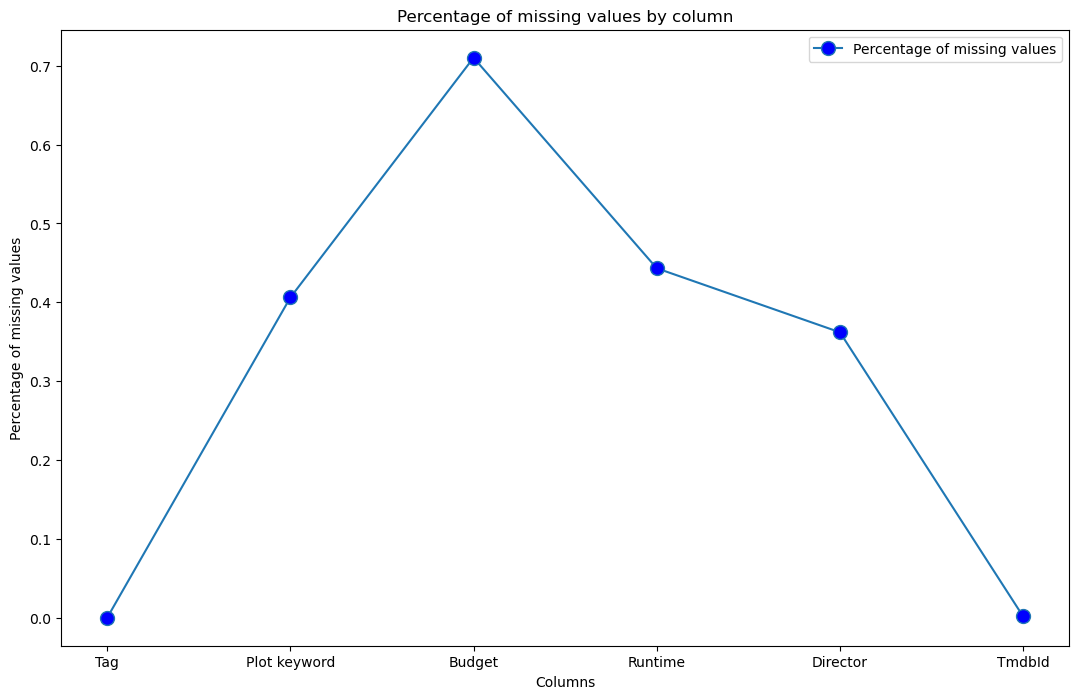

In [22]:
missing_data={'Tag': tag_nulls, 'Plot keyword': plot_keywords_nulls, 'Budget': budget_nulls,
              'Runtime': runtime_nulls, 'Director': director_nulls, 'TmdbId':tmdbId_nulls}
missing_data = pd.DataFrame(list(missing_data.items()),columns= ['Columns', 'Percentage of missing values'])

missing_data.plot(kind='line',x='Columns',y='Percentage of missing values',  
                  marker='o', linestyle='-', markersize=10, markerfacecolor='blue', figsize=(13, 8))
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values')
plt.title('Percentage of missing values by column')
plt.show()

For more visuals, one would perhaps want to see what relationships can be infered from the data sets or what relationships could be interesting to explore. This will require some creative thinking since some key columns such as budget and runtime are missing a significant amount of data

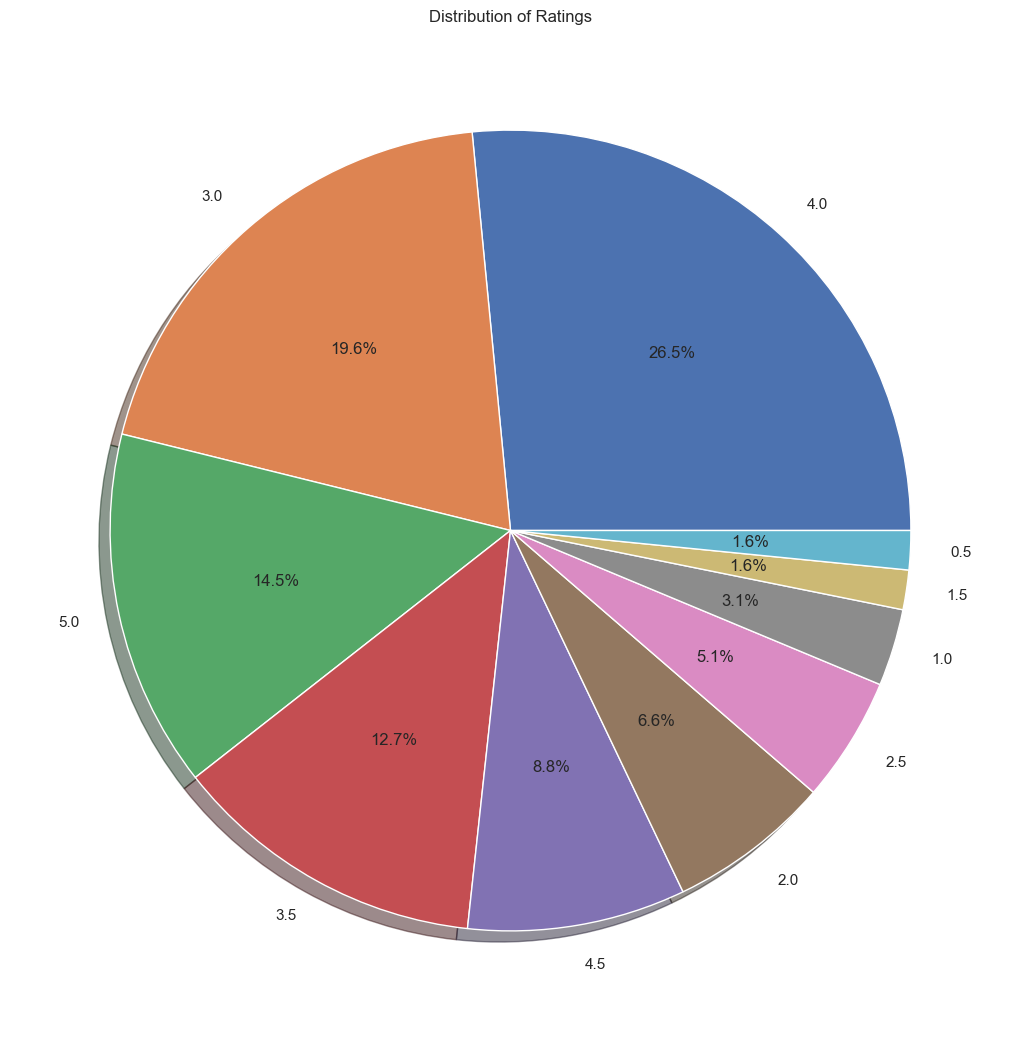

In [23]:
# Visualize the distribution of ratings
sns.set(rc={'figure.figsize':(27,13)})
rating_counts = df_train['rating'].value_counts()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Ratings')
plt.show()

Our exploration of the datasets does not end there. When movies are being titled, there could be a method in which movie titles are chosen in way that could result in higher rating or better responses from the audience. A word cloud can be used to show the most popular words in titles.

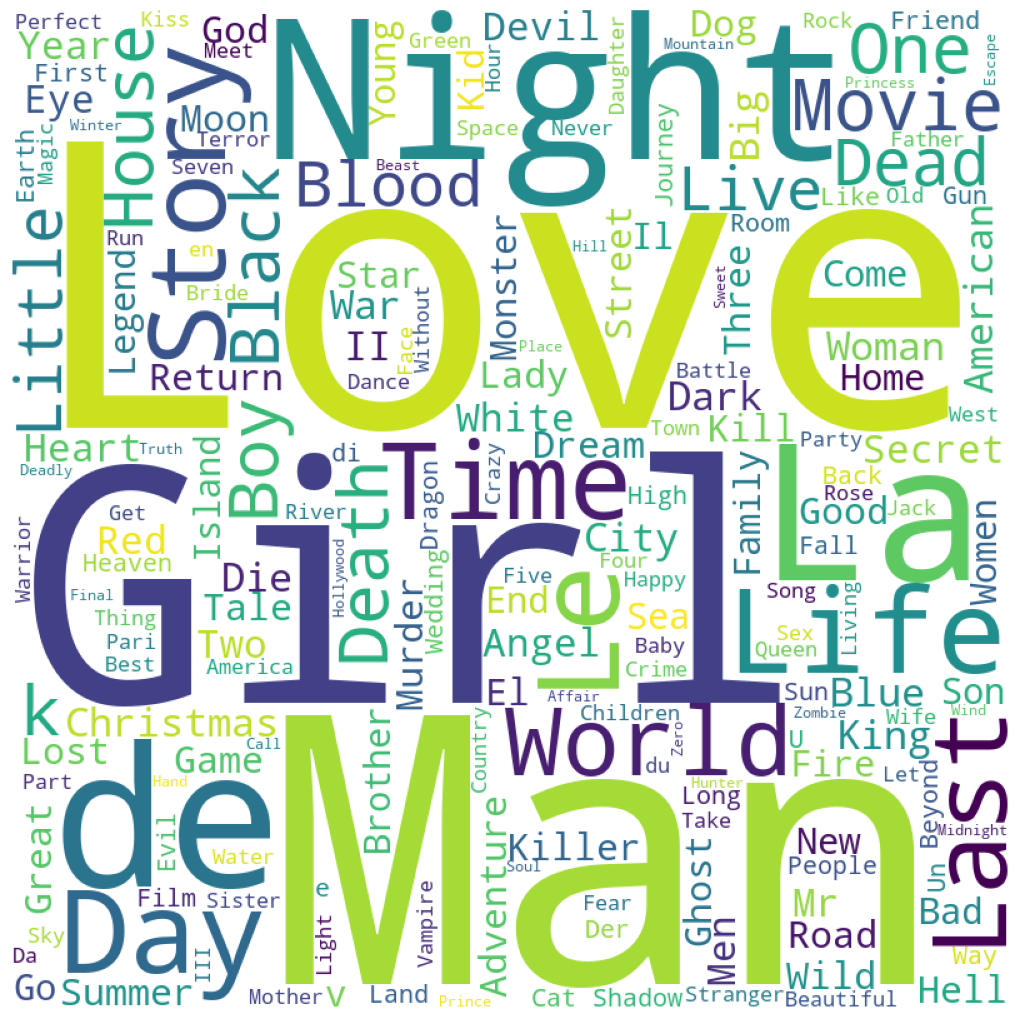

In [24]:
#create a set of english stopwords
stopwords = set(stopwords.words('english'))
#create a list of all the words in the 'title' column
words = ' '.join(movies['title'])
#create a wordcloud object
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)

# plot the wordcloud
plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

From the wordcloud it becomes apparent that words like Love, Man and Girl are largly popular when naming a movie. One could, at this point only speculate as to what role naming does to the popularity of a movie. Although it can be said that the name of the movie does play an important role in being as discriptive, eye catching and as relevant as possible so as to attract the intended target market.

With the exploration of the data done as much as possibe without making any changes to the data, it's clear that few relationships can be visualised from the data. To solve this, the Data has to be cleaned and try exploring the data further.

## Data Engineering


From the Exploratory Data Analysis, the columns from the imdb data are lacking a significant amount of information. In this phase of the project, it is important to drop those columns. At this point, it's important to remember that the aim of the project is to build a recommender for both  content based filtering and collaborative based filtering. This will have to kept in mind when changes are made. for instance, for content based filtering, columns such as genre, actors, director and budget might prove vital. hence it would not be adviseable to drop the the columns from the imdb dataframe completely. to deal with the missing values found in the EDA, dropping the rows with empty columns would be more productive so as to keep the information.

In [25]:
#to drop the empty rows
imdb_data.dropna(inplace=True)

Another thing that is visible is the plot keywords and title actor columns have the names mixed up, this might cause issues in the data not being properly displayed. To solve this, spliting the words using the split method would make the information more accessible. However the Imdb dataframe is not the only one with this issue, the column genre from also has the same issue. The same remedy will be applied to it as well.

In [26]:
#splitting the data from imdb_data
imdb_data[['plot_keywords', 'title_cast']] = imdb_data[['plot_keywords', 'title_cast']].apply(lambda x: x.str.split('|'))
imdb_data = imdb_data.explode('plot_keywords')
imdb_data = imdb_data.explode('title_cast')

In [27]:
#separating any null values
movies = movies[~movies["genres"].isnull()]
#splitting the genre column
movies["genres"] = movies["genres"].str.split("|")
movies = movies.explode("genres")

When looking at the title column from movies, the movie names are structured in a way whereby it is 'movie_name (year of release)'. this might prove inconvinient when searching for a movie, so extracting the year of release and removing it from the data could save time and make the code run more efficiently.

In [28]:
movies['title'] = movies['title'].str.extract('(.*) \(.*\)', expand=False)

Once these columns have been dealt with, the next step is moving into creating dataframe that would be suitable for the purposes of this project. First, since this is an unsupervised machine learning project, the df_test does not have a rating column, to create it below. Secondly, the timestamp column from df_train does not serve a purpose when it come to getting the ratings, so we'll have to drop it.

In [29]:
df_test['rating'] = df_test.assign(rating=None)['rating'].astype(float)
df_test

,userId,movieId,rating
0,1,2011,NaN
1,1,4144,NaN
2,1,5767,NaN
3,1,6711,NaN
4,1,7318,NaN
...,...,...,...
5000014,162541,4079,NaN
5000015,162541,4467,NaN
5000016,162541,4980,NaN
5000017,162541,5689,NaN


In [30]:
#dropping the timestamp column
df_train=df_train.drop(['timestamp'], axis=1)

We must be avoid at all costs having unnecessary data cluttering up the models. Below, we create a new dataframe specifically for the content based filtering. 

In [31]:
#feautures we want to keep
movies_genre = movies[['movieId','genres', 'title']]
cast = imdb_data[['movieId', 'title_cast']]
# Group the data by movieId in both dataframes
movies_genre = movies_genre.groupby('movieId').agg({'genres': '|'.join, 'title': 'first'})
cast = cast.groupby('movieId').agg({'title_cast': '|'.join})
# Merge the grouped dataframes on movieId
df_train2 = pd.merge(df_train, movies_genre, on='movieId', how='left')
df_train2 = pd.merge(df_train2, cast, on='movieId', how='left')
df_train2

,userId,movieId,rating,genres,title,title_cast
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,In Bruges,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...
1,106343,5,4.5,Comedy,Father of the Bride Part II,Steve Martin|Diane Keaton|Martin Short|Kimberl...
2,146790,5459,5.0,Action|Comedy|Sci-Fi,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...
3,106362,32296,2.0,Adventure|Comedy|Crime,Miss Congeniality 2: Armed and Fabulous,Sandra Bullock|Regina King|Enrique Murciano|Wi...
4,9041,366,3.0,Drama|Horror|Mystery|Thriller,Wes Craven's New Nightmare (Nightmare on Elm S...,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...
...,...,...,...,...,...,...
10000033,136395,99114,5.0,Action|Drama|Western,Django Unchained,Jamie Foxx|Christoph Waltz|Leonardo DiCaprio|K...
10000034,140078,553,3.0,Action|Drama|Western,Tombstone,Kurt Russell|Val Kilmer|Sam Elliott|Bill Paxto...
10000035,154807,56782,4.0,Drama|Western,There Will Be Blood,Daniel Day-Lewis|Martin Stringer|Matthew Brade...
10000036,85805,327,4.0,Action|Comedy|Sci-Fi,Tank Girl,Lori Petty|Ice-T|Naomi Watts|Don Harvey|Jeff K...


In [32]:
#feautures we want to keep
movies_genre = movies[['movieId','genres', 'title']]
cast = imdb_data[['movieId', 'title_cast']]
# Group the data by movieId in both dataframes
movies_genre = movies_genre.groupby('movieId').agg({'genres': '|'.join, 'title': 'first'})
cast = cast.groupby('movieId').agg({'title_cast': '|'.join})
# Merge the grouped dataframes on movieId
df_train2 = pd.merge(df_train, movies_genre, on='movieId', how='left')
df_train2 = pd.merge(df_train2, cast, on='movieId', how='left')
df_train2

,userId,movieId,rating,genres,title,title_cast
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,In Bruges,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...
1,106343,5,4.5,Comedy,Father of the Bride Part II,Steve Martin|Diane Keaton|Martin Short|Kimberl...
2,146790,5459,5.0,Action|Comedy|Sci-Fi,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...
3,106362,32296,2.0,Adventure|Comedy|Crime,Miss Congeniality 2: Armed and Fabulous,Sandra Bullock|Regina King|Enrique Murciano|Wi...
4,9041,366,3.0,Drama|Horror|Mystery|Thriller,Wes Craven's New Nightmare (Nightmare on Elm S...,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...
...,...,...,...,...,...,...
10000033,136395,99114,5.0,Action|Drama|Western,Django Unchained,Jamie Foxx|Christoph Waltz|Leonardo DiCaprio|K...
10000034,140078,553,3.0,Action|Drama|Western,Tombstone,Kurt Russell|Val Kilmer|Sam Elliott|Bill Paxto...
10000035,154807,56782,4.0,Drama|Western,There Will Be Blood,Daniel Day-Lewis|Martin Stringer|Matthew Brade...
10000036,85805,327,4.0,Action|Comedy|Sci-Fi,Tank Girl,Lori Petty|Ice-T|Naomi Watts|Don Harvey|Jeff K...


With the data engineering part done, the exploration of the data can continue.

### Second EDA

To continue with the EDA and exploring the kind of relationships that can be displayed once the data is cleaned. Now features which were not able to be displayed prior to cleaning such as the top rated genres in general can be easily displayed. 

Below the top 20 highly rated genres is displayed.

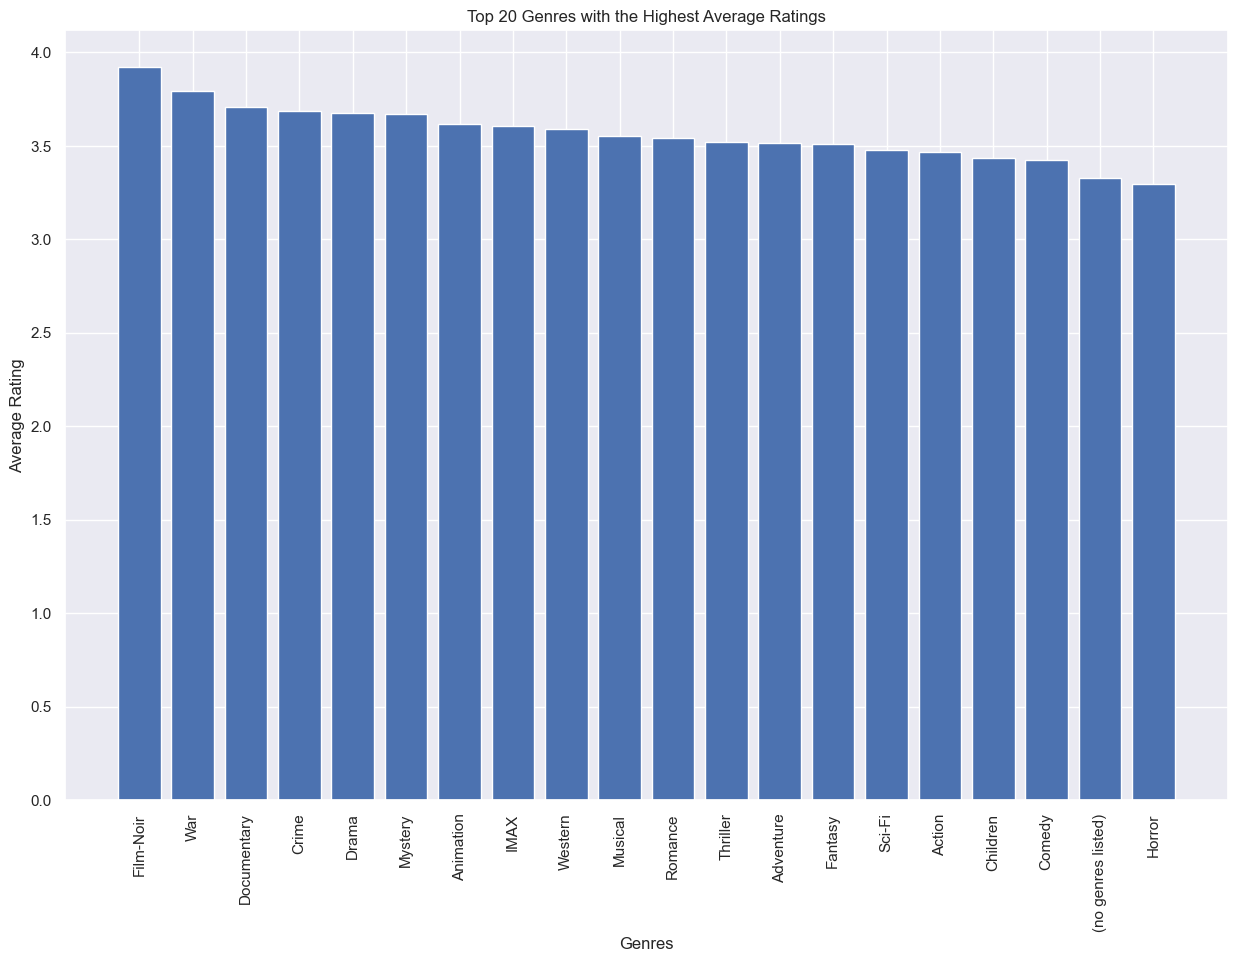

In [33]:
# Join the two dataframes based on the common column movieId
merged_df = pd.merge(df_train, movies, on='movieId')
# Group the data by the genres column and calculate the mean rating for each genre
genre_ratings = merged_df.groupby('genres')['rating'].mean().reset_index()
# Sort the data by mean rating in descending order
genre_ratings = genre_ratings.sort_values('rating', ascending=False)
# Keep only the top n genres
n = 20
genre_ratings = genre_ratings.head(n)

# Plot the genres with the highest ratings
plt.figure(figsize=(15, 10))
plt.bar(genre_ratings['genres'], genre_ratings['rating'])
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title(f'Top {n} Genres with the Highest Average Ratings')
plt.xticks(rotation=90)
plt.show()


From the graph, it becomes clear that novelty genres like Film Noir and War are the two most highly rated genres. It could be a play into the rarity and the unusualness of the films. Also seeing documentary, crime and drama in the top 5 most rated genres is quite intersting and could tell what the public is generally interested in. This can be used by executives to see which movies to direct or for companies that stream movies, what kind of movies to include more in their plartfom.

With this said, which movies have on average the highest ratings?
below, the top 20 films with the highest ratings are displayed.

In [34]:
#Join the two dataframes based on the common column movieId
merged_df = pd.merge(df_train, movies, on='movieId')
#Group the data by the genres column and calculate the mean rating for each genre
genre_ratings = merged_df.groupby('title')['rating'].mean().reset_index()
#Sort the data by mean rating in descending order
genre_ratings = genre_ratings.sort_values('rating', ascending=False)
#Keep only the top n genres
n = 20
genre_ratings = genre_ratings.head(n)
#Display the genres with the highest ratings as a table
print(genre_ratings[['title', 'rating']])

                                                   title  rating
43666                                           What Now     5.0
22119                                         Lonely Boy     5.0
36260                                   The Big Exchange     5.0
8496                                           Convicted     5.0
5775                                  Bowery at Midnight     5.0
34446                             Storm - Letter of Fire     5.0
22131                               Lonesome Dove Church     5.0
38128                                    The Last Bullet     5.0
38127                     The Last Brickmaker in America     5.0
44949                               You, Me & the Circus     5.0
5786                               Boxers and Ballerinas     5.0
17409  How to Train Your Husband or (How to Pick Your...     5.0
1512             Adventures of Mowgli: Return to Mankind     5.0
38121                                      The Landlords     5.0
8505                     

Seeing the top 20 highest rated movies and genres, it would be interesting to see the directors relationships to the actors. Firstly seeing which directors have worked with the most actors overall, This is a great indicator to show who works well with others. Which in the long term, helps the investor gauge who they would like to invest in when it comes to directors. 

Below the top 25 directors with the most actors worked with is displayed.

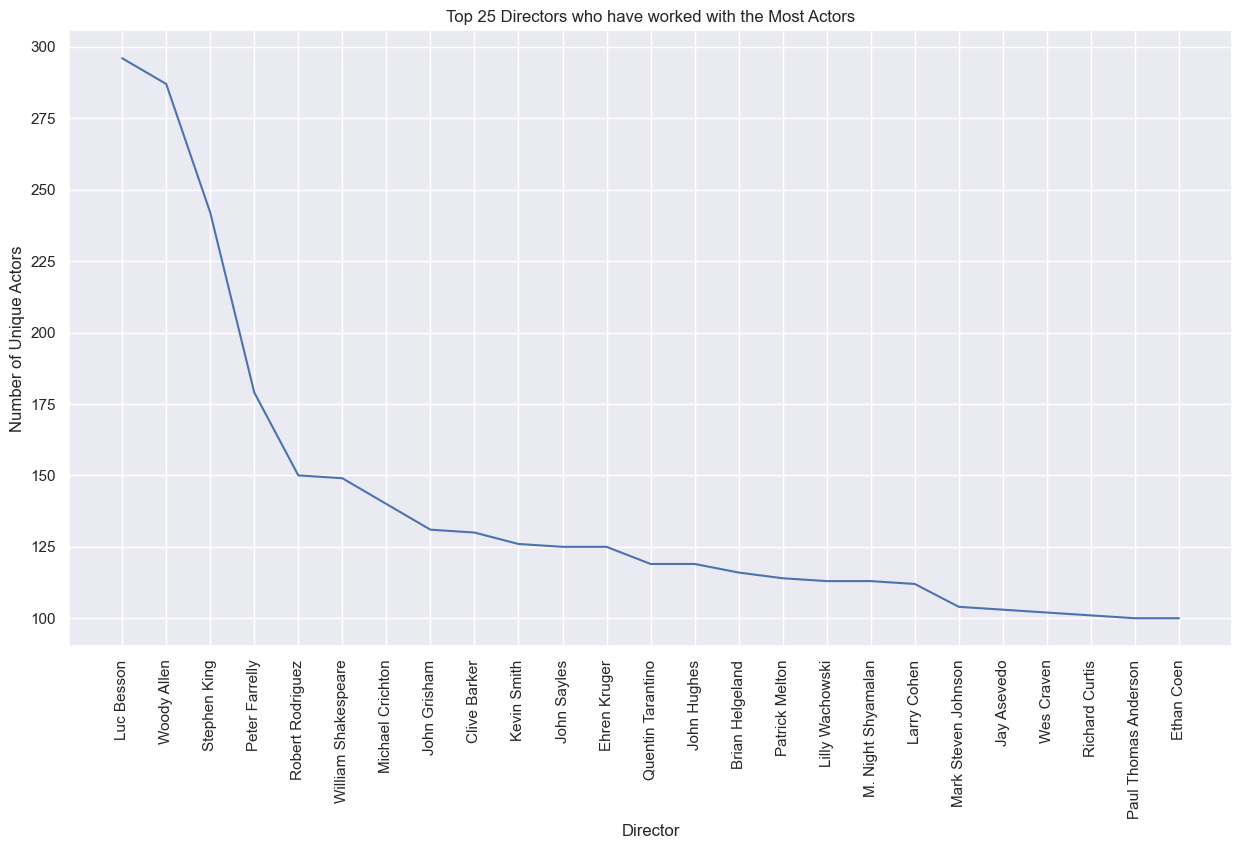

In [35]:
# Create a new dataframe that contains only the director, cast, and movieId columns
df_director_cast = imdb_data[['director', 'title_cast', 'movieId']]
# Group the data by the director and count the number of unique actors they have worked with
director_actor_counts = df_director_cast.groupby(['director'])['title_cast'].nunique().reset_index()
# Sort the data by the number of unique actors in descending order
director_actor_counts = director_actor_counts.sort_values('title_cast', ascending=False)
# Keep only the top 20 directors
top_25 = director_actor_counts.head(25)

# Plot the line graph
plt.figure(figsize=(15, 8))
plt.plot(top_25['director'], top_25['title_cast'])
plt.xlabel('Director')
plt.ylabel('Number of Unique Actors')
plt.title('Top 25 Directors who have worked with the Most Actors')
plt.xticks(rotation=90)
plt.show()

A few interesting insights come up, first to be noted is how the graph almost plateus around 125 actors. This could be due to the level of experience directors have or the willingness of actors to work with the directors. A funny observation is seeing how the list includes directors like classical playwright, actor and poet William Shakespeare. Who died in the year 1616

If that is the case, it might be intersting to see which actors have acted in the highest number of movies. This also helps in seeing who is more popular to work with which is a good sign because making movies is an art but still a business. You want to have the best possible cast, best director and the best production team.

To show the actors with the most movies, we use the following graph:

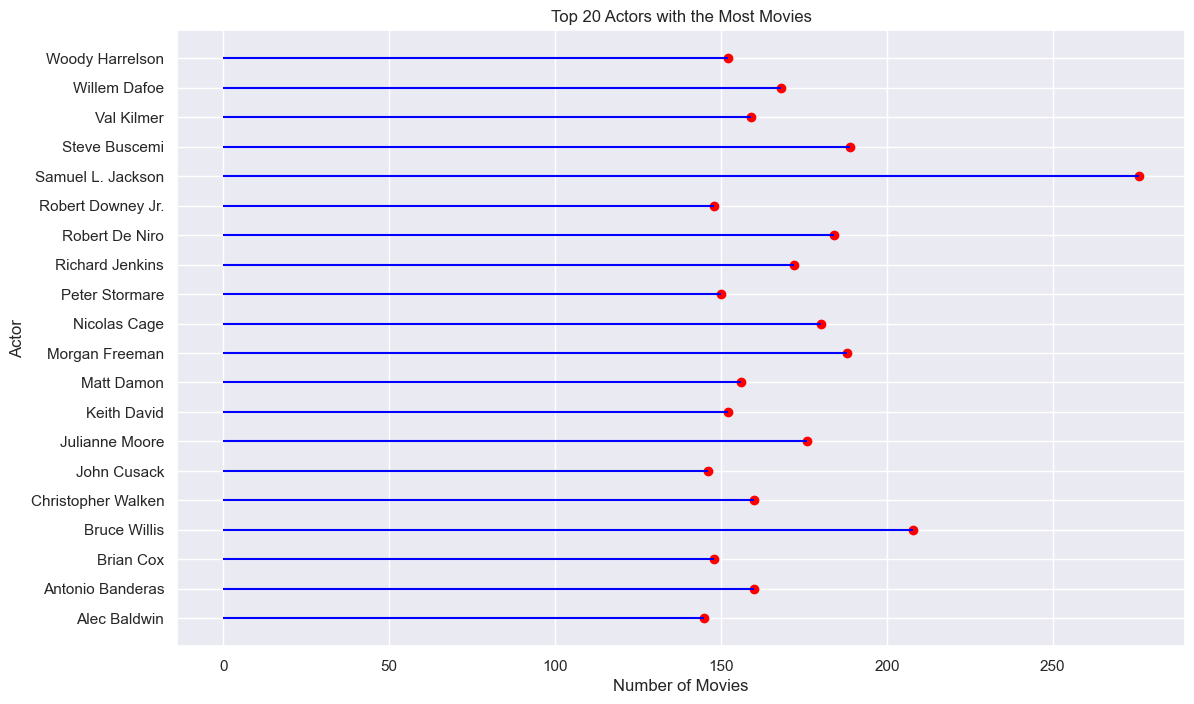

In [36]:
# Count the number of movies each actor appears in
actor_counts = imdb_data['title_cast'].value_counts()
# Only keep the top 20 actors
actor_counts = actor_counts.head(20)
# Sort the actors alphabetically
actor_counts = actor_counts.sort_index()

# Plot the data as a lollipop chart
plt.figure(figsize=(13,8))
plt.hlines(y=actor_counts.index, xmin=0, xmax=actor_counts.values, color='blue')
plt.scatter(x=actor_counts.values, y=actor_counts.index, color='red')
plt.xlabel("Number of Movies")
plt.ylabel("Actor")
plt.title("Top 20 Actors with the Most Movies")
plt.show()

From above, Samuel L. Jackson is the most popular actor  by a huge margin followed by Bruce Willis, who also leads by a sizable margin. This is a good indicator to show the actors experience and value. 

There are plenty of relationships that could be explored and displayed. It can really be done ad nauseam. With the visualisations done already. some key relationships can be drawn. But before closing off this part of the project. Let us look at the directors with the longest runtime. One can compare this with the number of actors a director has worked with. It can also show which directors are given the most creative freedom during filming.

to plot directors with the highest runtimes:

In [37]:
pip install squarify

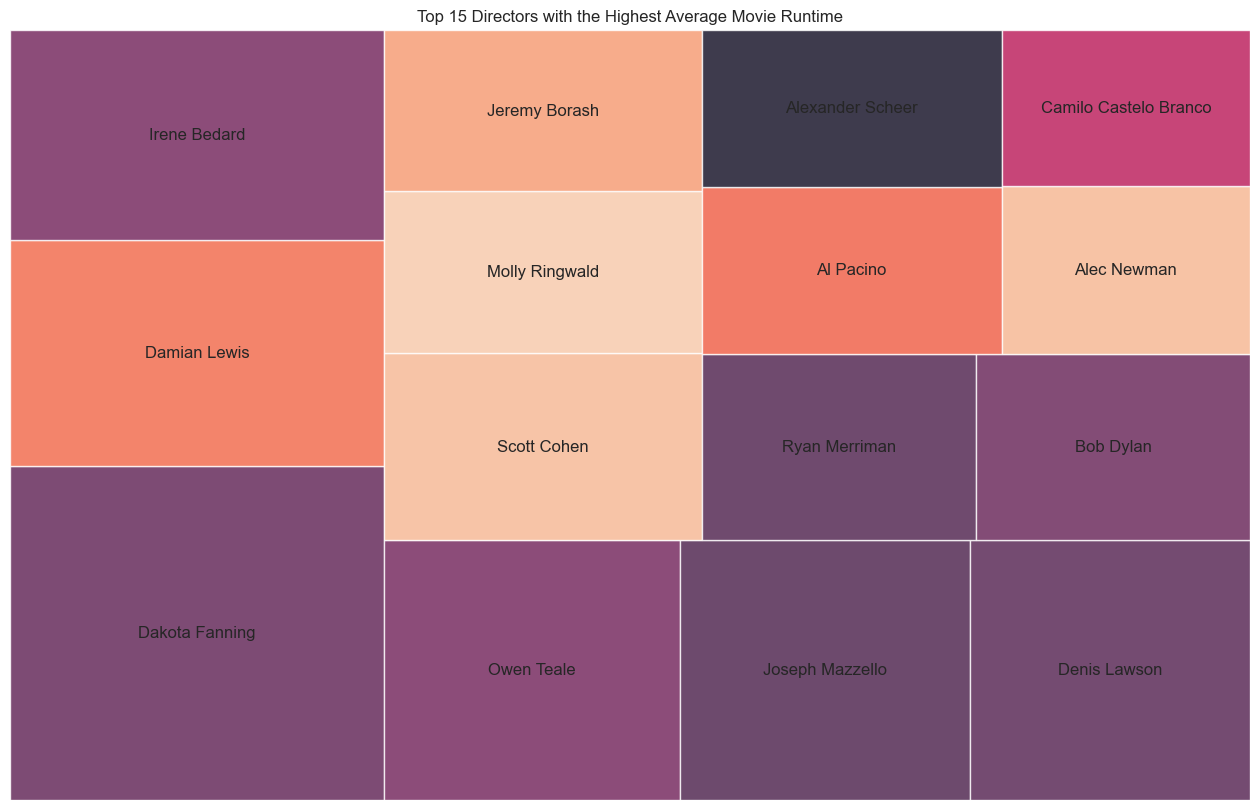

In [38]:
import squarify
import matplotlib.pyplot as plt

# Calculate the average runtime for each director
director_runtime = imdb_data.groupby("director")["runtime"].mean().reset_index()
# Sort the directors by average runtime in descending order
director_runtime = director_runtime.sort_values("runtime", ascending=False)
# Keep only the top 15 directors with the highest average runtime
director_runtime = director_runtime.head(15)

# Plot the Treemap
plt.figure(figsize=(16, 10))
squarify.plot(sizes=director_runtime["runtime"], label=director_runtime["director"], alpha=.8)
plt.axis('off')
plt.title("Top 15 Directors with the Highest Average Movie Runtime")
plt.show()

What is quite interesting to see is how the directors shown here are different from the directors who have worked with the most amount of actors. It could be drawn that a longer runtime is not popular amongst actor. Also runtime does affect production costs, meaning a movie needs to gross more for it to break even. Translating to a higher risk when it comes to the return of investment.

With the exploration of the data done, the project can continue to build the models and fit them